<a href="https://colab.research.google.com/github/JosephLMeredith/Programming/blob/main/Data_Comp_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

H0 = Among the most frequent customers, there is no difference in profitability when comparing all categories - "Premium", "Choice", "Popcorn", and "Shake/Trim" on a 'Per Gram' basis.

H1 = Among the most frequent customers, the cannabis category "Shake/Trim" is the least profitable category in comparison to all other categories - "Premium", "Choice", and "Popcorn" on a 'Per Gram' basis.

In [ ]:
# Load all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_error, r2_score
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
import statsmodels.api as sm
from scipy.stats import f

In [ ]:
# Get Your Data: copy and paste the path to your data file
# This file needs to be downloaded and then uploaded into colab.
# Click on the file folder in the left column, click on the page with an up arrow,
# Select file and bring it into the worksheet. Once complete, click on the 3 dots and copy the file path.

df = pd.read_csv('/content/Data_Comp_Project_Calculations.csv')

# Check the shape (number of rows and columns)
print(df.shape)
print('\n')

# Get the name of all columns
df.columns

(2304, 9)




Index(['Invoice', 'Customer', 'Sales', 'Product', 'Category', 'Quantity',
       'Cost', 'Revenue', 'Profit'],
      dtype='object')

In [ ]:
# Check the types of different columns (categorical or numerical)
# 'int64' = numerical, 'object' = categorical.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Invoice   2304 non-null   int64  
 1   Customer  2304 non-null   object 
 2   Sales     2304 non-null   object 
 3   Product   2304 non-null   object 
 4   Category  2304 non-null   object 
 5   Quantity  2304 non-null   int64  
 6   Cost      2304 non-null   float64
 7   Revenue   2304 non-null   float64
 8   Profit    2304 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 162.1+ KB


In [ ]:
# Take a look at the first five rows from your data
df.head()

,Invoice,Customer,Sales,Product,Category,Quantity,Cost,Revenue,Profit
0,125620,Twisacts,1/4/23,Das Butter,Premium,270,0.95,1.21,0.25
1,125620,Twisacts,1/4/23,Das Butter,Premium,306,0.95,1.20,0.25
2,125920,EscaInc.,1/9/23,Das Butter,Shake/Trim,454,0.00,0.16,0.16
3,125920,EscaInc.,1/9/23,Das Butter,Shake/Trim,454,0.00,0.16,0.16
4,125920,EscaInc.,1/9/23,Das Butter,Shake/Trim,454,0.00,0.16,0.16


In [ ]:
# Check the groups and associated number of rows by running a loop only on the categorical columns
for column in df.select_dtypes(include=['object']).columns:
    print(column)
    print(df[column].value_counts())
    print('\n')

Customer
Customer
Twicbles    534
Stra LLC    271
Nomasing    216
Twisacts    208
ClowLick    111
           ... 
Greey #2      1
Greey #1      1
OKC ding      1
CantCall      1
Flav LLC      1
Name: count, Length: 84, dtype: int64


Sales
Sales
6/18/24    46
6/30/23    40
7/11/24    36
1/10/25    33
1/23/25    32
           ..
6/5/23      1
5/12/23     1
7/17/25     1
7/23/25     1
1/19/23     1
Name: count, Length: 301, dtype: int64


Product
Product
Das Butter     819
Glitterbomb    810
Red Runtz      675
Name: count, dtype: int64


Category
Category
Premium       1409
Shake/Trim     672
Popcorn        218
Choice           5
Name: count, dtype: int64




In [ ]:
# Check for any NaN values in dataframe
df.isna().sum()

,0
Invoice,0
Customer,0
Sales,0
Product,0
Category,0
Quantity,0
Cost,0
Revenue,0
Profit,0


In [ ]:
# Produce the product list (in this case, narrowed down to the top three strains of cannabis by sales volume)
# 'Das Butter' comprises 35.55% of all sales (within the top three strains), we will use this strain for reference
# Percentage = (Specified strain sales/Total sales) * 100 -> (819/2304) * 100 -> .3554 * 100 -> 35.5468 -> rounded to 35.55
df.Product.value_counts()


,count
Product,
Das Butter,819
Glitterbomb,810
Red Runtz,675


In [ ]:
# Create a dummy variable for the 'Customer' variable where Twicbles = 1 else 0. This customer is chosen due to highest sales
# volume within the observable timeframe.
import pandas as pd
df['Customer_clean'] = df['Customer'].str.strip().str.lower()
df['is_Twicbles'] = (df['Customer_clean'] == 'twicbles').astype(int)


In [ ]:
# Calculating percent of sales by this producer compared to all other customers within the observable timeframe.
df['is_Twicbles'].value_counts()

# Result - Twicbles comprises 23.18% of all sales for observable timeframe
# Percentage = (Specified customer sales/Total sales) * 100 -> (534/2304) * 100 -> .23177 * 100 -> 23.177 -> rounded to 23.18

,count
is_Twicbles,
0,1770
1,534


In [ ]:
# Additional: calculate the mean for the two groups of 'is_Twicbles' variable for 'Cost'
df.groupby('is_Twicbles')['Cost'].mean()
# You can compare the mean profits of Twicbles vs. all others,
# but to be certain that this difference is statistically significant, you need a T-test

,Cost
is_Twicbles,
0,0.688593
1,0.900393


In [ ]:
# Perform an F test for QUANTITY
# Remember, for F test, p > 0.05 = equal variance; p < 0.05 = unequal variance

group_variable = 'is_Twicbles'
dependent_variable = 'Quantity'

group3 = df[df[group_variable] == 0][dependent_variable]
group4 = df[df[group_variable] == 1][dependent_variable]

var1 = group3.var(ddof=1)
var2 = group4.var(ddof=1)

# Compute F-statistic and degrees of freedom
f_stat = var1 / var2 if var1 > var2 else var2 / var1
df1 = len(group3) - 1
df2 = len(group4) - 1

# Two-tailed p-value
p_value_f = 2 * min(f.cdf(f_stat, df1, df2), 1 - f.cdf(f_stat, df1, df2))


# Apply t-test for PRODUCT and QUANTITY
equal_var = True if p_value_f > 0.05 else False
t_test = ttest_ind(group3, group4, equal_var=equal_var)

# Output
print('Assume equal variances?', equal_var)
print('F-statistic:', f_stat)
print('F test p-value:', p_value_f)
print('t-statistic:', t_test.statistic)
print('t-test p-value:', t_test.pvalue)

if p_value_f < 0.05:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Assume equal variances? False
F-statistic: 7.193118497813604
F test p-value: 2.220446049250313e-16
t-statistic: 4.395669859944388
t-test p-value: 1.1564984941127015e-05
Reject the null hypothesis


In [ ]:
# Perform an F test for COST
# Remember, for F test, p > 0.05 = equal variance; p < 0.05 = unequal variance

group_variable = 'is_Twicbles'
dependent_variable = 'Cost'

group5 = df[df[group_variable] == 0][dependent_variable]
group6 = df[df[group_variable] == 1][dependent_variable]

var1 = group5.var(ddof=1)
var2 = group6.var(ddof=1)

# Compute F-statistic and degrees of freedom
f_stat = var1 / var2 if var1 > var2 else var2 / var1
df1 = len(group5) - 1
df2 = len(group6) - 1

# Two-tailed p-value
p_value_f = 2 * min(f.cdf(f_stat, df1, df2), 1 - f.cdf(f_stat, df1, df2))

# Apply t-test for PRODUCT and COST
equal_var = True if p_value_f > 0.05 else False
t_test = ttest_ind(group5, group6, equal_var=equal_var)

# Output
print('Assume equal variances?', equal_var)
print('F-statistic:', f_stat)
print('F test p-value:', p_value_f)
print('t-statistic:', t_test.statistic)
print('t-test p-value:', t_test.pvalue)

if p_value_f < 0.05:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Assume equal variances? False
F-statistic: 4.574208804377242
F test p-value: 2.220446049250313e-16
t-statistic: -9.473960856367855
t-test p-value: 7.630086366700587e-21
Reject the null hypothesis


In [ ]:
# Perform an F test for REVENUE
# Remember, for F test, p > 0.05 = equal variance; p < 0.05 = unequal variance

group_variable = 'is_Twicbles'
dependent_variable = 'Revenue'

group7 = df[df[group_variable] == 0][dependent_variable]
group8 = df[df[group_variable] == 1][dependent_variable]

var1 = group7.var(ddof=1)
var2 = group8.var(ddof=1)

# Compute F-statistic and degrees of freedom
f_stat = var1 / var2 if var1 > var2 else var2 / var1
df1 = len(group7) - 1
df2 = len(group8) - 1

# Two-tailed p-value
p_value_f = 2 * min(f.cdf(f_stat, df1, df2), 1 - f.cdf(f_stat, df1, df2))

# Apply t-test for PRODUCT and REVENUE
equal_var = True if p_value_f > 0.05 else False
t_test = ttest_ind(group7, group8, equal_var=equal_var)

# Output
print('Assume equal variances?', equal_var)
print('F-statistic:', f_stat)
print('F test p-value:', p_value_f)
print('t-statistic:', t_test.statistic)
print('t-test p-value:', t_test.pvalue)

if p_value_f < 0.05:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Assume equal variances? False
F-statistic: 24.155193268701836
F test p-value: 2.220446049250313e-16
t-statistic: -28.952646664371443
t-test p-value: 5.945413058230982e-156
Reject the null hypothesis


In [ ]:
# Perform an F test and T test for PROFIT
# Remember, for F test, p > 0.05 = equal variance; p < 0.05 = unequal variance

group_variable = 'is_Twicbles'
dependent_variable = 'Profit'

group1 = df[df[group_variable] == 0][dependent_variable]
group2 = df[df[group_variable] == 1][dependent_variable]

var1 = group1.var(ddof=1)
var2 = group2.var(ddof=1)

# Compute F-statistic and degrees of freedom
f_stat = var1 / var2 if var1 > var2 else var2 / var1
df1 = len(group1) - 1
df2 = len(group2) - 1

# Two-tailed p-value
p_value_f = 2 * min(f.cdf(f_stat, df1, df2), 1 - f.cdf(f_stat, df1, df2))

# Apply t-test for PRODUCT and PROFIT
equal_var = True if p_value_f > 0.05 else False
t_test = ttest_ind(group1, group2, equal_var=equal_var)

# Step 5: Output
print('Assume equal variances?', equal_var)
print('F-statistic:', f_stat)
print('F test p-value:', p_value_f)
print('t-statistic:', t_test.statistic)
print('t-test p-value:', t_test.pvalue)

if t_test.pvalue < 0.05:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')


Assume equal variances? False
F-statistic: 1.7871230754600766
F test p-value: 4.218847493575595e-15
t-statistic: -15.678743330777147
t-test p-value: 2.1309633934139552e-50
Reject the null hypothesis


In [ ]:
# --- imports (make sure these are present) ---
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings

# Silence noisy warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# --- config ---
continuous_cols_to_test = ['Quantity', 'Cost', 'Revenue', 'Profit']
categorical_cols = ['Category', 'Product']
alpha = 0.05

for continuous_col in continuous_cols_to_test:
    for categorical_col in categorical_cols:
        print("___________________________________________________________")
        print(f"Analyzing {continuous_col} by {categorical_col}")
        print("___________________________________________________________")

        # 0) Clean subset for this pair of columns (drop NaNs)
        sub = df[[continuous_col, categorical_col]].dropna().copy()

        # Optional: ensure categorical dtype
        if not pd.api.types.is_categorical_dtype(sub[categorical_col]):
            sub[categorical_col] = sub[categorical_col].astype('category')

        # Quick sanity checks for groups
        group_sizes = sub.groupby(categorical_col)[continuous_col].size()
        n_groups = (group_sizes > 0).sum()
        if n_groups < 2:
            print("Not enough groups for ANOVA (need ≥2). Skipping.\n\n")
            continue

        # 1) One-way ANOVA
        formula = f'{continuous_col} ~ C({categorical_col})'
        model = ols(formula, data=sub).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        print("ANOVA Table:")
        print(anova_table)
        print()

        # 2) Pull the correct p-value for the factor row
        try:
            p_value = anova_table.loc[f'C({categorical_col})', 'PR(>F)']
        except KeyError:
            # fallback if index labels differ (rare)
            # try to find the first row that starts with 'C('
            factor_rows = [idx for idx in anova_table.index if str(idx).startswith('C(')]
            if len(factor_rows) == 0:
                print("Could not locate factor row in ANOVA table. Skipping Tukey.\n\n")
                continue
            p_value = anova_table.loc[factor_rows[0], 'PR(>F)']

        if p_value < alpha:
            print("ANOVA is significant. Proceeding with Tukey's HSD post-hoc test.\n")

            # Tukey requires at least 2 groups with ≥2 obs each
            valid_groups = group_sizes[group_sizes >= 2].index
            sub_tukey = sub[sub[categorical_col].isin(valid_groups)].copy()
            if sub_tukey[categorical_col].nunique() < 2:
                print("Not enough groups with ≥2 observations for Tukey. Skipping.\n\n")
                continue

            tukey_results = pairwise_tukeyhsd(
                endog=sub_tukey[continuous_col].values,
                groups=sub_tukey[categorical_col].values,
                alpha=alpha
            )

            print("Tukey's HSD Post-Hoc Test:")
            print(tukey_results.summary())
        else:
            print("ANOVA is not statistically significant. No post-hoc test is needed.")

        print("\n")


___________________________________________________________
Analyzing Quantity by Category
___________________________________________________________
ANOVA Table:
                   sum_sq      df          F        PR(>F)
C(Category)  2.118022e+07     3.0  45.767066  1.006663e-28
Residual     3.548002e+08  2300.0        NaN           NaN

ANOVA is significant. Proceeding with Tukey's HSD post-hoc test.

Tukey's HSD Post-Hoc Test:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
 group1   group2    meandiff p-adj    lower     upper   reject
--------------------------------------------------------------
 Choice    Popcorn  446.7183 0.0579   -10.006  903.4427  False
 Choice    Premium  236.1617 0.5361  -216.214  688.5373  False
 Choice Shake/Trim  425.3682 0.0749  -27.8838  878.6201  False
Popcorn    Premium -210.5567    0.0 -284.0461 -137.0672   True
Popcorn Shake/Trim  -21.3502 0.8981 -100.0543   57.3539  False
Premium Shake/Trim  189.2065    0.0  141.8684  236.5446   Tru

In [ ]:
# Find the count of each 'Product' category within the dataframe
df.Category.value_counts()
# Product category 'Shake/Trim' comprises 29.17% of all sales
# Product category 'Premium' comprises 61.15% of all sales

,count
Category,
Premium,1409
Shake/Trim,672
Popcorn,218
Choice,5


In [ ]:
# Create dummy variables for the 'Category', 'Product' columns
df = pd.get_dummies(df, columns=['Category', 'Product'], drop_first=False)
df.head()

,Invoice,Customer,Sales,Quantity,Cost,Revenue,Profit,Customer_clean,is_Twicbles,Category_Choice,Category_Popcorn,Category_Premium,Category_Shake/Trim,Product_Das Butter,Product_Glitterbomb,Product_Red Runtz
0,125620,Twisacts,1/4/23,270,0.95,1.21,0.25,twisacts,0,False,False,True,False,True,False,False
1,125620,Twisacts,1/4/23,306,0.95,1.20,0.25,twisacts,0,False,False,True,False,True,False,False
2,125920,EscaInc.,1/9/23,454,0.00,0.16,0.16,escainc.,0,False,False,False,True,True,False,False
3,125920,EscaInc.,1/9/23,454,0.00,0.16,0.16,escainc.,0,False,False,False,True,True,False,False
4,125920,EscaInc.,1/9/23,454,0.00,0.16,0.16,escainc.,0,False,False,False,True,True,False,False


/tmp/ipython-input-4238494509.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Sales_dt"] = pd.to_datetime(df["Sales"], errors="coerce")  # optional: keep if needed later


                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     982.8
Date:                Sat, 04 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:58:54   Log-Likelihood:                 203.27
No. Observations:                2304   AIC:                            -388.5
Df Residuals:                    2295   BIC:                            -336.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1241    

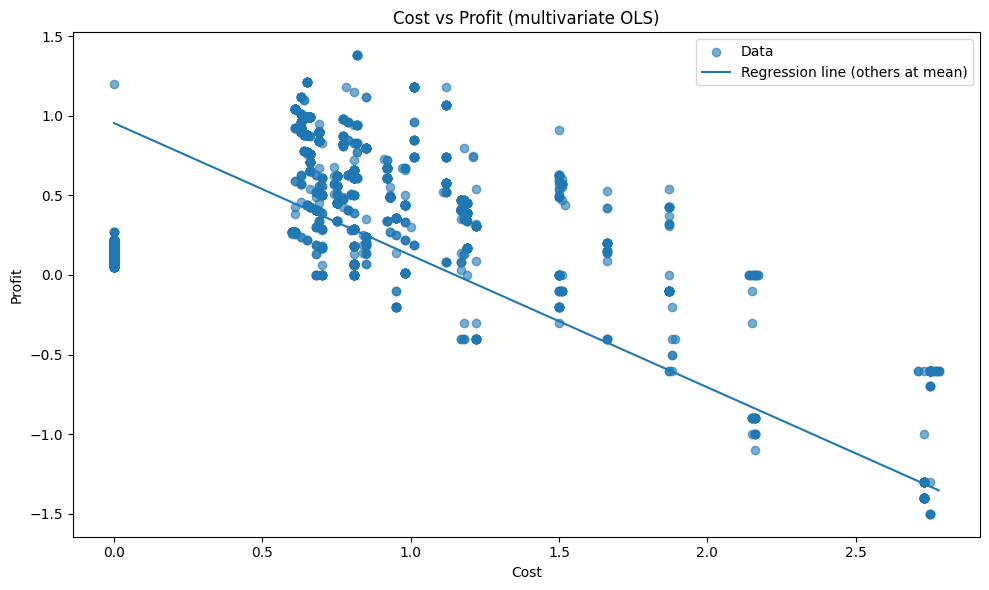


Standardized coefficients (|beta| sorted):
 Category_Premium       1.273854
Cost                  -1.164137
Category_Popcorn       0.462795
Category_Choice        0.094984
Product_Glitterbomb    0.073308
Product_Red Runtz      0.050225
is_Twicbles           -0.049169
Quantity              -0.025500
dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- 1) Parse / drop non-numeric columns ---
# If you don't need the date for this model, just parse then drop it
if "Sales" in df.columns:
    df["Sales_dt"] = pd.to_datetime(df["Sales"], errors="coerce")  # optional: keep if needed later
    df = df.drop(columns=["Sales"])  # drop the string date column used to cause object dtype

# --- 2) Force all dummy/indicator columns to 0/1 numerics ---
boolish_cols = [
    "is_Twicbles",
    "Category_Choice", "Category_Popcorn", "Category_Premium", "Category_Shake/Trim",
    "Product_Das Butter", "Product_Glitterbomb", "Product_Red Runtz"
]

for col in boolish_cols:
    if col in df.columns:
        # normalize common encodings, then cast to numeric 0/1
        df[col] = (
            df[col]
            .replace({True: 1, False: 0, "True": 1, "False": 0, "Yes": 1, "No": 0, "1": 1, "0": 0})
            .pipe(pd.to_numeric, errors="coerce")
        )

# --- 3) Ensure core numerics are numeric ---
num_cols = ["Quantity", "Cost", "Revenue", "Profit"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Optional: drop rows with any NaNs in the columns we’ll use
features = [
    "Quantity", "Cost", "is_Twicbles",
    "Category_Choice", "Category_Premium", "Category_Popcorn",
    "Product_Glitterbomb", "Product_Red Runtz"
]
target = "Profit"

use_cols = [c for c in features + [target] if c in df.columns]
clean = df[use_cols].dropna(axis=0, how="any").copy()

X = clean[features]
y = clean[target]

# --- 4) Fit OLS ---
X_sm = sm.add_constant(X, has_constant="add")
results = sm.OLS(y, X_sm).fit()
print(results.summary())

# --- 5) Plot Cost vs Profit holding others at their means ---
plt.figure(figsize=(10, 6))
plt.scatter(X["Cost"], y, alpha=0.6, label="Data")

cost_grid = np.linspace(X["Cost"].min(), X["Cost"].max(), 100)
X_line = pd.DataFrame(np.tile(X.mean().values, (100, 1)), columns=X.columns)
X_line["Cost"] = cost_grid
X_line_sm = sm.add_constant(X_line, has_constant="add")
y_pred = results.predict(X_line_sm)

plt.plot(cost_grid, y_pred, label="Regression line (others at mean)")
plt.xlabel("Cost"); plt.ylabel("Profit"); plt.title("Cost vs Profit (multivariate OLS)")
plt.legend(); plt.tight_layout(); plt.show()

# --- 6) Standardized coefficients (beta weights) ---
x_sd = X.std(ddof=0)
y_sd = y.std(ddof=0)
beta = results.params.drop("const", errors="ignore")
beta_std = (beta * (x_sd[beta.index] / y_sd)).sort_values(key=lambda s: s.abs(), ascending=False)
print("\nStandardized coefficients (|beta| sorted):\n", beta_std)


Summary:

When we control other features, compared to Category "Shake/Trim":

Category "Premium" positively affects Profit by $1.22 per gram,

Category "Choice" positively affects Profit by $0.95 per gram,

Category "Popcorn" positively affects Profit by $0.74 per gram.